### Compute sentiment of DD posts 

* For now, just use TextBlob package that assigns sentiment score between -1, 1 (In the future, employ WSB-specific dictionary for positive/negative)
* Merge with ticker mention data, and only work with single ticker mention posts 
* Merge with return data, and compute 3 month cumulative abnormal return over subsequent 3 months, 5 days, and next day

In [1]:
# import packages 
import pandas as pd
from textblob import TextBlob

#### Load DD posts 

In [2]:
dd_df = pd.read_pickle('/Volumes/Elements/Research/Reddit_Credibility/Data/dd_df_sample.pkl')

#### Create title and body sentiment scores

In [3]:
dd_df['title_sentiment'] =dd_df['title'].apply(lambda title: TextBlob(title).sentiment.polarity)

dd_df['body_sentiment'] =dd_df['body'].apply(lambda body: TextBlob(body).sentiment.polarity)

In [4]:
dd_df.body_sentiment.describe()

count    9197.000000
mean        0.071052
std         0.106230
min        -0.900000
25%         0.009091
50%         0.074074
75%         0.125000
max         1.000000
Name: body_sentiment, dtype: float64

#### Time series plot - sentiment over time 

In [5]:
# create date and month variable
dd_df['date'] = dd_df['timestamp'].dt.date
dd_df['month'] = dd_df['timestamp'].dt.to_period('M')

# daily and monthly average sentiment score variables 
daily_avg = dd_df.groupby(['date'])[['title_sentiment', 'body_sentiment']].agg('mean')
month_avg = dd_df.groupby(['month'])[['title_sentiment', 'body_sentiment']].agg('mean')

# reset index 
month_avg = month_avg.reset_index()
daily_avg = daily_avg.reset_index()

<AxesSubplot:xlabel='month'>

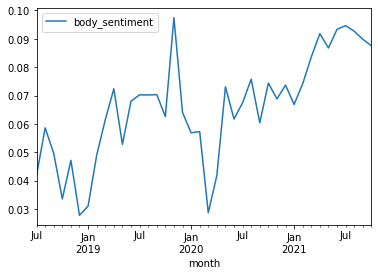

In [6]:
month_avg.plot(x = 'month', y = 'body_sentiment')

In [7]:
dd_df.shape

(9197, 16)

#### Merge with ticker mention data

In [8]:
ticker_mention = pd.read_csv('/Volumes/Elements/Research/Reddit_Credibility/Data/ticker_collection_2021.csv')

# only keep multi_ticker not equal to 1 
ticker_mention = ticker_mention[ticker_mention['multi_ticker'] != 1]

ticker_mention = ticker_mention[['url', 'ticker']]

dd_df = dd_df.merge(ticker_mention, on = 'url')

dd_df = dd_df.dropna()

In [9]:
dd_df = dd_df.dropna()

#### Merge with CRSP Returns 

In [10]:
# load crsp 
crsp = pd.read_csv('/Volumes/Elements/Research/Reddit_Credibility/Data/ReturnMeasures.csv')

# date
crsp['date'] = pd.to_datetime(crsp['date'], format = '%Y%m%d')

# merge with dd_df
dd_df['date'] = pd.to_datetime(dd_df['date'])
dd_df = dd_df.sort_values(['date'])
crsp = crsp.sort_values(['date'])
dd_df = pd.merge_asof(left = dd_df, right = crsp, on = 'date', left_by = 'ticker', right_by = 'TICKER', direction = 'forward' )

#### Save

In [13]:
dd_df.to_csv('/Volumes/Elements/Research/Reddit_Credibility/Data/DDPosts_Sentiment_Returns.csv')